In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

task = pd.read_csv('train_data.csv')
task

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [2]:
print("Number of rows:", task.shape[0])
print("Number of columns:", task.shape[1])

Number of rows: 614
Number of columns: 13


In [3]:
task.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [4]:
task.axes

[RangeIndex(start=0, stop=614, step=1),
 Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
        'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
        'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
       dtype='object')]

In [41]:
task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loan_ID                  614 non-null    object 
 1   Gender                   614 non-null    int32  
 2   Married                  614 non-null    int32  
 3   Education                614 non-null    int32  
 4   Self_Employed            614 non-null    int32  
 5   ApplicantIncome          614 non-null    float64
 6   CoapplicantIncome        614 non-null    float64
 7   LoanAmount               614 non-null    float64
 8   Credit_History           614 non-null    string 
 9   Loan_Status              614 non-null    int64  
 10  Dependents_0             614 non-null    int64  
 11  Dependents_1             614 non-null    int64  
 12  Dependents_2             614 non-null    int64  
 13  Dependents_3+            614 non-null    int64  
 14  Property_Area_Urban      6

In [42]:
task.isnull().sum()

Loan_ID                    0
Gender                     0
Married                    0
Education                  0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Credit_History             0
Loan_Status                0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Property_Area_Urban        0
Property_Area_Rural        0
Property_Area_Semiurban    0
Loan_Amount_Term_360.0     0
Loan_Amount_Term_120.0     0
Loan_Amount_Term_240.0     0
Loan_Amount_Term_180.0     0
Loan_Amount_Term_60.0      0
Loan_Amount_Term_300.0     0
Loan_Amount_Term_480.0     0
Loan_Amount_Term_36.0      0
Loan_Amount_Term_84.0      0
Loan_Amount_Term_12.0      0
dtype: int64

# Visualization

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Count'>

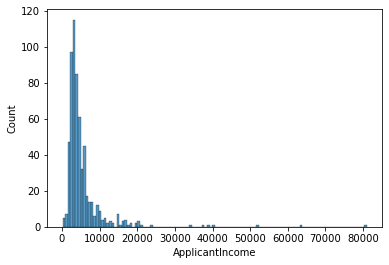

In [7]:
sns.histplot(task.ApplicantIncome)

<AxesSubplot:xlabel='Education', ylabel='ApplicantIncome'>

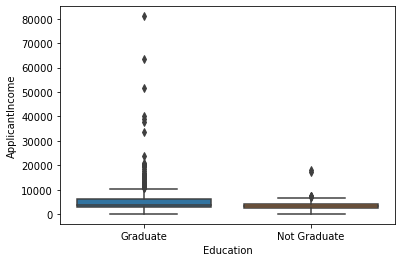

In [8]:
sns.boxplot(x='Education', y='ApplicantIncome', data=task, width=0.8)

<AxesSubplot:xlabel='Gender', ylabel='count'>

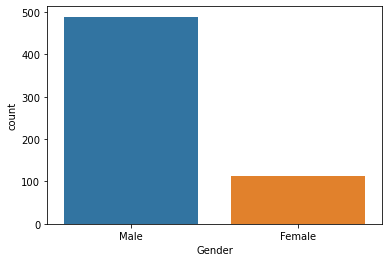

In [9]:
sns.countplot(x="Gender", data=task)

In [10]:
modified=task
modified['Loan_Status'] = task['Loan_Status'].apply(lambda x: 0 if x=="N" else 1)
modified.groupby('Credit_History')['Loan_Status'].mean()

Credit_History
0.0    0.078652
1.0    0.795789
Name: Loan_Status, dtype: float64

Another interesting variable is credit history, to check how it affects the Loan Status I can turn it into binary then calculate it's mean for each value of credit history. A value close to 1 indicates a high loan success rate

People with a credit history a way more likely to pay their loan, 0.13 and 0.79. This means that credit history will be an influential variable in our model.

# Preprocessing

In [11]:
pip install category_encoders

In [12]:
task['Gender'].fillna(method='ffill', inplace=True)
task['Married'].fillna(task['Married'].value_counts().index[0], inplace=True)
task['Dependents'].fillna(method='bfill', inplace=True)
task['Self_Employed'].fillna(method='ffill', inplace=True)
task['Loan_Amount_Term'].fillna(task['Loan_Amount_Term'].value_counts().index[0], inplace=True)
task['Credit_History'].fillna(method='bfill', inplace=True)
task['LoanAmount'].fillna(task['LoanAmount'].median(), inplace=True)

In [13]:
task['Loan_Amount_Term'] = task['Loan_Amount_Term'].apply(str)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categories = ['Gender', 'Married', 'Education', 'Self_Employed']
for i in categories:
    task[i]= label_encoder.fit_transform(task[i])
    
from category_encoders.one_hot import OneHotEncoder
ohe = OneHotEncoder(use_cat_names=True)
x = pd.DataFrame(ohe.fit_transform(task[['Dependents', 'Property_Area', 'Loan_Amount_Term']]))
task = task.join(x)

task.drop(['Dependents', 'Property_Area', 'Loan_Amount_Term'], inplace=True, axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

task['ApplicantIncome'] = scaler.fit_transform(task[['ApplicantIncome']])
task['CoapplicantIncome'] = scaler.fit_transform(task[['CoapplicantIncome']])
task['LoanAmount'] = scaler.fit_transform(task[['LoanAmount']])

# Modelling

In [15]:
#Setting the value for dependent and independent variables
X = task.drop(['Loan_Status','Loan_ID'], 1)
y = task['Loan_Status']

In [16]:
from sklearn.model_selection import KFold

kf  = KFold(n_splits = 10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(553, 25) (553,)
(61, 25) (61,)


# Logistic Regression

In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=100000)

# fit model
model_1.fit(X_train, y_train)

# predict test dataset
y_pred_1 = model_1.predict(X_test)

In [19]:
# predict probabilities
y_pred_1_proba = model_1.predict_proba(X_test)

from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_1_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

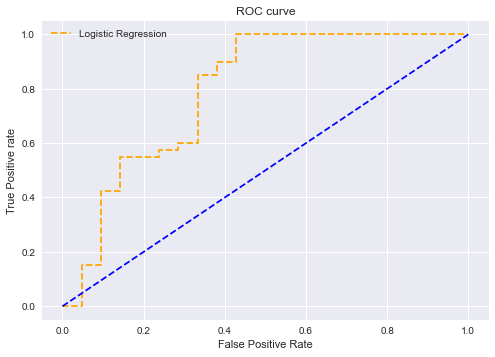

In [20]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')

# x label
plt.xlabel('False Positive Rate')

# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, y_pred_1_proba[:,1])

print("AUC Score for Logistic Regression:", auc_score1)

AUC Score for Logistic Regression: 0.7904761904761904


In [22]:
a = pd.DataFrame({"Actual value": y_test, "Predicted value (Logistic Regression)": y_pred_1})
a.head()

,Actual value,Predicted value (Logistic Regression)
553,0,0
554,0,0
555,1,1
556,1,1
557,1,1


              precision    recall  f1-score   support

           0       1.00      0.57      0.73        21
           1       0.82      1.00      0.90        40

    accuracy                           0.85        61
   macro avg       0.91      0.79      0.81        61
weighted avg       0.88      0.85      0.84        61



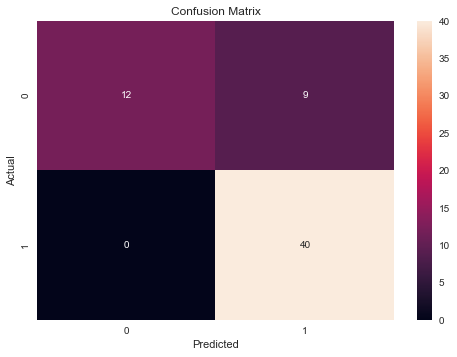

In [23]:
# Evaluating the Logistic Regression Model
# Confusion matrix and classification 

from sklearn.metrics import classification_report, confusion_matrix

matrix_1 = confusion_matrix(y_test, y_pred_1)

sns.heatmap(matrix_1, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

print(classification_report(y_test, y_pred_1))

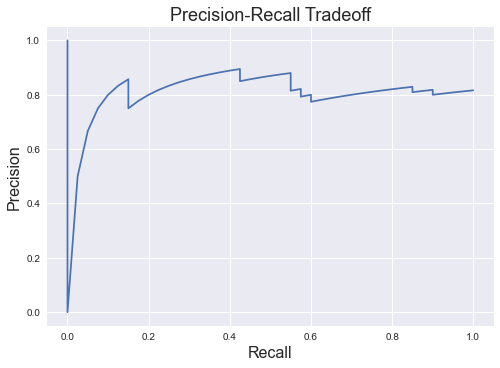

In [24]:
from sklearn.metrics import precision_recall_curve 

y_decision_function_1 = model_1.decision_function(X_test)
precision_1, recall_1, threshold_1 = precision_recall_curve(y_test, y_decision_function_1)
plt.plot(recall_1, precision_1)
plt.title('Precision-Recall Tradeoff', fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.show()

# KNN

Minimum Error: 0.2459016393442623 at K = 5


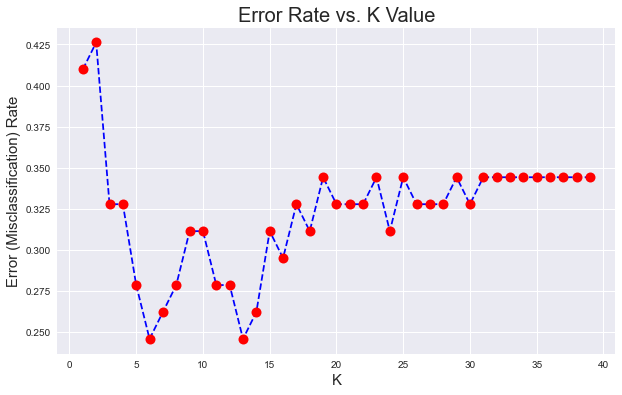

In [25]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K', fontsize=15)
plt.ylabel('Error (Misclassification) Rate', fontsize=15)
print("Minimum Error:", min(error_rate), "at K =", error_rate.index(min(error_rate)))

Maximum Accuracy: 0.7540983606557377 at K = 5


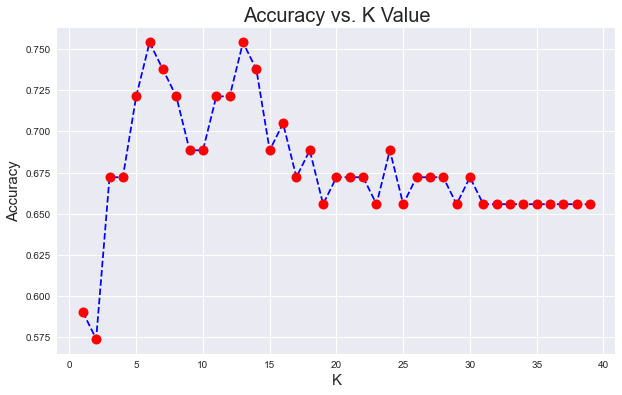

In [26]:
acc = []
from sklearn.metrics import accuracy_score
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40), acc, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value', fontsize=20)
plt.xlabel('K', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
print("Maximum Accuracy:", max(acc), "at K =", acc.index(max(acc)))

In [27]:
model_2 = KNeighborsClassifier(n_neighbors=6)

# fit model
model_2.fit(X_train, y_train)

# predict test dataset
y_pred_2 = model_2.predict(X_test)

In [28]:
# predict probabilities
y_pred_2_proba = model_2.predict_proba(X_test)

from sklearn.metrics import roc_curve

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_2_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

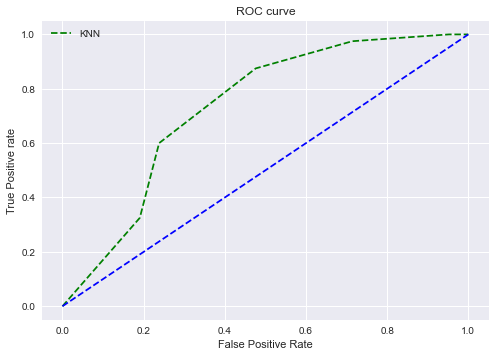

In [29]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--', color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')

# x label
plt.xlabel('False Positive Rate')

# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score2 = roc_auc_score(y_test, y_pred_2_proba[:,1])

print("AUC Score for KNN:", auc_score2)

AUC Score for KNN: 0.7315476190476191


In [31]:
b = pd.DataFrame({"Actual value": y_test, "Predicted value (KNN)": y_pred_2})
b.head()

,Actual value,Predicted value (KNN)
553,0,0
554,0,0
555,1,1
556,1,1
557,1,1


              precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.78      0.88      0.82        40

    accuracy                           0.75        61
   macro avg       0.73      0.70      0.71        61
weighted avg       0.75      0.75      0.74        61



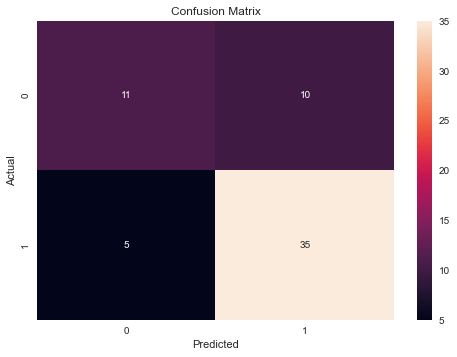

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
matrix_2 = confusion_matrix(y_test, y_pred_2)

sns.heatmap(matrix_2, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

print(classification_report(y_test, y_pred_2))

# SVM

In [33]:
from sklearn.svm import SVC

model_3 = SVC(C=9.0, kernel='linear', probability=True)

model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)

In [34]:
y_pred_3_proba = model_3.predict_proba(X_test)

from sklearn.metrics import roc_curve

fpr3, tpr3, thresh3 = roc_curve(y_test, y_pred_3_proba[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

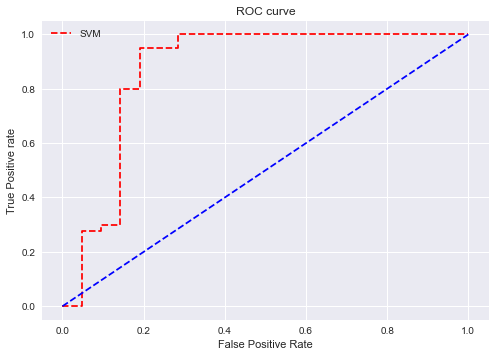

In [35]:
plt.style.use('seaborn')

plt.plot(fpr3, tpr3, linestyle='--', color='red', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title('ROC curve')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

auc_score3 = roc_auc_score(y_test, y_pred_3_proba[:,1])

print("AUC Score for SVM:", auc_score3)

AUC Score for SVM: 0.8702380952380953


In [37]:
c = pd.DataFrame({"Actual value": y_test, "Predicted value (SVM)": y_pred_3})
c.head()

,Actual value,Predicted value (SVM)
553,0,0
554,0,0
555,1,1
556,1,1
557,1,1


              precision    recall  f1-score   support

           0       1.00      0.57      0.73        21
           1       0.82      1.00      0.90        40

    accuracy                           0.85        61
   macro avg       0.91      0.79      0.81        61
weighted avg       0.88      0.85      0.84        61



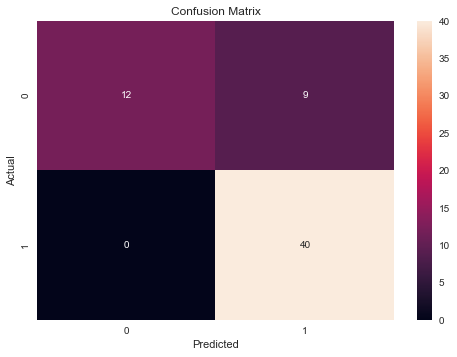

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

matrix_3 = confusion_matrix(y_test, y_pred_3)

sns.heatmap(matrix_3, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

print(classification_report(y_test, y_pred_3))

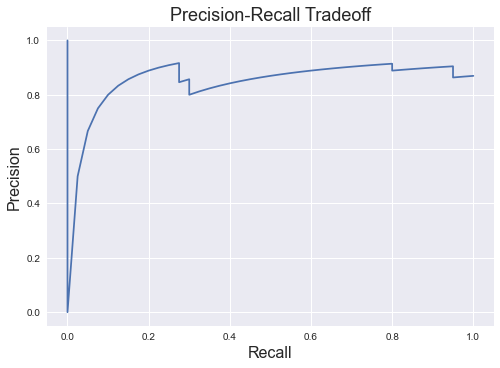

In [39]:
from sklearn.metrics import precision_recall_curve 

y_decision_function_3 = model_3.decision_function(X_test)
precision_3, recall_3, threshold_3 = precision_recall_curve(y_test, y_decision_function_3)
plt.plot(recall_3, precision_3)
plt.title('Precision-Recall Tradeoff', fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.show()